In [1]:
#!pip install sklearn
#!pip install bcml4pheno
#!pip install tensorflow 

In [2]:
import os
import csv
import math 
import numpy as np
import pandas as pd
import ROOT
from bcml4pheno import bcml_model
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

Welcome to JupyROOT 6.22/06


2022-09-16 08:44:45.818746: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /Collider/ROOT/installROOT/lib::/Collider/ROOT/installROOT/lib/:/Collider/fastjet/lib:/Collider/fastjet/lib64:/Collider/LHAPDF/lib
2022-09-16 08:44:45.818785: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [3]:
print(os.getcwd())

/disco4/SIMULACIONES/Cristian/Pheno_BSM/Leptoquarks_searches/04_ML_analysis


In [4]:
def read_csv(folder, name):
    dict_={}
    ax=next(os.walk(folder))[2]
    ax.sort(reverse = True )
    for file in ax:
        if "Cutflow" in file: continue
        elif name in file:
            try:
                df=pd.read_csv(
                    os.path.join(folder,file)
                )
                dict_.update(
                    {file.removesuffix(f"_{name}") : df}
                )
            except:
                pass
    return dict_

def load_all_csv(folder):
    data_dict={}
    results_names=[
        #hadronic selection
        "b_tau_tau_hadronic_zero_jets",
        "b_tau_tau_hadronic_(al)one_jet",
        "b_b_tau_tau_hadronic",
        #semileptonic selection
        "b_tau_tau_semileptonic_zero_jets",
        "b_tau_tau_semileptonic_(al)one_jet",
        "b_b_tau_tau_semileptonic",
        #leptonic selection
        "b_tau_tau_leptonic_zero_jets",
        "b_tau_tau_leptonic_(al)one_jet",
        "b_b_tau_tau_leptonic"
    ]
    for name in results_names:
        data_dict.update({name: read_csv(folder,f"{name}.csv")})
    return data_dict


In [5]:
def prepare_features(data_dict,name='',channel="",features=[]):
    signal_feature=[]
    for i in range(data_dict[channel][name].shape[0]):
        row=[]
        for feature in features:
            row+=[data_dict[channel][name][feature][i]]        
        signal_feature.append(row)
    return np.array(signal_feature)

def concat_signals(data_dict,signal_list,channel,features):
    names=signal_list.copy()
    name_0=names.pop(0)
    arr=prepare_features(data_dict,name_0,channel,features)[:,:]
    for name in names:
        arr=np.concatenate((arr,prepare_features(data_dict,name,channel,features)[:,:]))
    np.random.shuffle(arr)
    return arr

def concat_channels(data_dict,signal_list,channels,features):
    chs=channels.copy()
    ch_0=chs.pop(0)
    arr=concat_signals(data_dict,signal_list,ch_0,features)
    for channel in chs:
        arr=np.concatenate((arr,concat_signals(data_dict,signal_list,channel,features)[:,:]))
    np.random.shuffle(arr)
    return arr

In [6]:
def prepare_to_train (signal,bkg):
    bkg_vsize=min([len(signal),len(bkg)])
    signal_vsize=bkg_vsize

    pred=signal[:signal_vsize, :]
    pred=np.concatenate((pred,bkg[:bkg_vsize, :]))
    
    labels=np.zeros(np.shape(pred)[0])
    labels[:signal_vsize] = 1
    
    return pred , labels
def get_yield(csv_files_path,signal_list,channel):
    df=pd.read_csv(
            os.path.join(
                csv_files_path,
                f"Cutflow_{channel}.csv"
            )
        )
    yields=0
    for name in signal_list:
        yields+=df[name][(df.shape[0]-1)]
    return yields
def get_yields(csv_files_path,names,channels):
    dict_={}
    for channel in channels:
        dict_[channel]={}
        for name in names: 
            dict_[channel][name]=get_yield(csv_files_path,[name],channel)
    return dict_

In [7]:
from ROOT import *

def Draw_Discrtiminator(data_dict,name,channels,csv_files_path,images_folder,model,features):
    c1 = TCanvas( f'c-{name}', '', 0, 0, 1280, 720)
    c1.SetGrid()
    c1.SetLogy()
    hs = THStack(name,name)
    colors = [kBlue,kRed,3, 7, 6, kBlack, 2,  9, 1, 43, 97, 38, 3, 7, 6, kBlack, 2, 4, 8]
    hist_dict={}
    for i, channel in enumerate(channels):
        h = TH1F(f"{name}_{channel}",f"{name}_{channel};score;nevents(137/fb)", 100, 0.0,1.0)
        h.SetLineWidth(1)
        h.SetLineColor(kBlack)
        h.SetFillColor(colors[i])
        for score in model.predict_proba(concat_signals(data_dict,[name],channel,features)):
            h.Fill(score)
        h.Scale(get_yield(csv_files_path,[name],channel)/h.Integral())
        hist_dict[channel]=h
        hs.Add(h)
    hs.Draw("HIST")
    c1.SaveAs(os.path.join(os.getcwd(),images_folder,f"{name}.png"))
    return (name,hist_dict)

In [8]:
folder_out=os.path.join(
    os.path.dirname(os.getcwd()),
    "03_delphes_analysis"
)
csv_files_path=os.path.join(folder_out,"csv_files")
print(csv_files_path)

data=load_all_csv(csv_files_path)

print(list(data.keys()))

/disco4/SIMULACIONES/Cristian/Pheno_BSM/Leptoquarks_searches/03_delphes_analysis/csv_files
['b_tau_tau_hadronic_zero_jets', 'b_tau_tau_hadronic_(al)one_jet', 'b_b_tau_tau_hadronic', 'b_tau_tau_semileptonic_zero_jets', 'b_tau_tau_semileptonic_(al)one_jet', 'b_b_tau_tau_semileptonic', 'b_tau_tau_leptonic_zero_jets', 'b_tau_tau_leptonic_(al)one_jet', 'b_b_tau_tau_leptonic']


In [9]:
channel="b_b_tau_tau_hadronic"
#channels=[
    #"b_tau_tau_hadronic_(al)one_jet",
    #"b_tau_tau_hadronic_zero_jets",
    #"b_b_tau_tau_hadronic"
#]
channels=[channel]

In [10]:
a=list(data[channel]["ww"])
a.sort(reverse = True)
a

['pT_{b_{2}}(GeV)',
 'pT_{b_{1}}(GeV)',
 'pT_{#tau_{2}}(GeV)',
 'pT_{#tau_{1}}(GeV)',
 'light_jets_multiplicity',
 'Q_#tau_{1}Q_#tau_{2}',
 'Mass_{b_{2}}(GeV)',
 'Mass_{b_{1}}(GeV)',
 'Mass_{#tau_{2}}(GeV)',
 'Mass_{#tau_{1}}(GeV)',
 'MET(GeV)',
 'Energy_{b_{2}}(GeV)',
 'Energy_{b_{1}}(GeV)',
 'Energy_{#tau_{2}}(GeV)',
 'Energy_{#tau_{1}}(GeV)',
 '#phi_{b_{2}}',
 '#phi_{b_{1}}',
 '#phi_{MET}',
 '#phi_{#tau_{2}}',
 '#phi_{#tau_{1}}',
 '#eta_{b_{2}}',
 '#eta_{b_{1}}',
 '#eta_{#tau_{2}}',
 '#eta_{#tau_{1}}',
 '#Delta{pT}_{b_{2}#tau_{2}}(GeV)',
 '#Delta{pT}_{b_{2}#tau_{1}}(GeV)',
 '#Delta{pT}_{b_{1}b_{2}}(GeV)',
 '#Delta{pT}_{b_{1}#tau_{2}}(GeV)',
 '#Delta{pT}_{b_{1}#tau_{1}}(GeV)',
 '#Delta{pT}_{#tau_{1}#tau_{2}}(GeV)',
 '#Delta{R}_{b_{2}#tau_{2}}',
 '#Delta{R}_{b_{2}#tau_{1}}',
 '#Delta{R}_{b_{1}b_{2}}',
 '#Delta{R}_{b_{1}#tau_{2}}',
 '#Delta{R}_{b_{1}#tau_{1}}',
 '#Delta{R}_{#tau_{1}#tau_{2}}',
 '#Delta{#vec{p}}_{b_{2}#tau_{2}}(GeV)',
 '#Delta{#vec{p}}_{b_{2}#tau_{1}}(GeV)',
 '#Delta{#v

In [11]:
features=[
    'light_jets_multiplicity',
    'MET(GeV)',
    '#phi_{MET}',
    
    'Mass_{b_{1}}(GeV)',
    'pT_{b_{1}}(GeV)',
    '#phi_{b_{1}}',
    '#eta_{b_{1}}',
    
    'Mass_{#tau_{1}}(GeV)',
    'pT_{#tau_{1}}(GeV)',
    '#phi_{#tau_{1}}',
    '#eta_{#tau_{1}}',
    
    'Mass_{#tau_{2}}(GeV)',
    'pT_{#tau_{2}}(GeV)',
    '#phi_{#tau_{2}}',
    '#eta_{#tau_{2}}'
]

In [12]:
mass=1500
name=
signal_names=[
    name=f"LQ_LQ_{mass}"
]
bkg_names=[
    "ttbar",
    "stop",
    "z_jets",
    "w_jets",
    "ww",
    "wz",
    "zz"
]

signal= concat_channels(data,signal_names,channels,features)
bkg= concat_channels(data,bkg_names,channels,features)

In [13]:
sig_yield=get_yields(csv_files_path,signal_names,channels)
bkg_yield=get_yields(csv_files_path,bkg_names,channels)
print(sig_yield)
print(bkg_yield)

{'b_b_tau_tau_hadronic': {'Tau_LQ_1500': 15.78259140857143}}
{'b_b_tau_tau_hadronic': {'ttbar': 44833.05889691348, 'stop': 3668.223105681818, 'z_jets': 4459.745413975855, 'w_jets': 7669.306893344798, 'ww': 16.5130953088, 'wz': 34.6863949319797, 'zz': 103.88704366560002}}


In [14]:
pred1 , labels1= prepare_to_train(signal,bkg)
trainPred, testPred, trainLab, testLab = train_test_split(pred1, labels1, test_size=0.25)

logreg_model = bcml_model(
    make_pipeline(
        StandardScaler(), 
        LogisticRegression()
    )
)

logreg_model.fit(trainPred, trainLab)

In [15]:
logreg_model.tpr(testLab, preds=testPred)

0.9755077658303465

In [16]:
logreg_model.fpr(testLab, preds=testPred)

0.018995098039215685

In [17]:
signal_names=[name,f"Tau_LQ_{mass}"]
images_folder=f"{channels[0]}-Mlq_{mass}"
os.system(f"rm -rf '{images_folder}'")
os.system(f"mkdir -p '{images_folder}'")
def mapping(name):
    return Draw_Discrtiminator(data,name,channels,csv_files_path,images_folder,logreg_model,features)
histograms=dict(map(mapping,signal_names+bkg_names))

Info in <TCanvas::Print>: png file /disco4/SIMULACIONES/Cristian/Pheno_BSM/Leptoquarks_searches/04_ML_analysis/b_b_tau_tau_hadronic-Mlq_1500/Tau_LQ_1500.png has been created
Info in <TCanvas::Print>: png file /disco4/SIMULACIONES/Cristian/Pheno_BSM/Leptoquarks_searches/04_ML_analysis/b_b_tau_tau_hadronic-Mlq_1500/LQ_LQ_1500.png has been created
Info in <TCanvas::Print>: png file /disco4/SIMULACIONES/Cristian/Pheno_BSM/Leptoquarks_searches/04_ML_analysis/b_b_tau_tau_hadronic-Mlq_1500/ttbar.png has been created
Info in <TCanvas::Print>: png file /disco4/SIMULACIONES/Cristian/Pheno_BSM/Leptoquarks_searches/04_ML_analysis/b_b_tau_tau_hadronic-Mlq_1500/stop.png has been created
Info in <TCanvas::Print>: png file /disco4/SIMULACIONES/Cristian/Pheno_BSM/Leptoquarks_searches/04_ML_analysis/b_b_tau_tau_hadronic-Mlq_1500/z_jets.png has been created
Info in <TCanvas::Print>: png file /disco4/SIMULACIONES/Cristian/Pheno_BSM/Leptoquarks_searches/04_ML_analysis/b_b_tau_tau_hadronic-Mlq_1500/w_jets.p

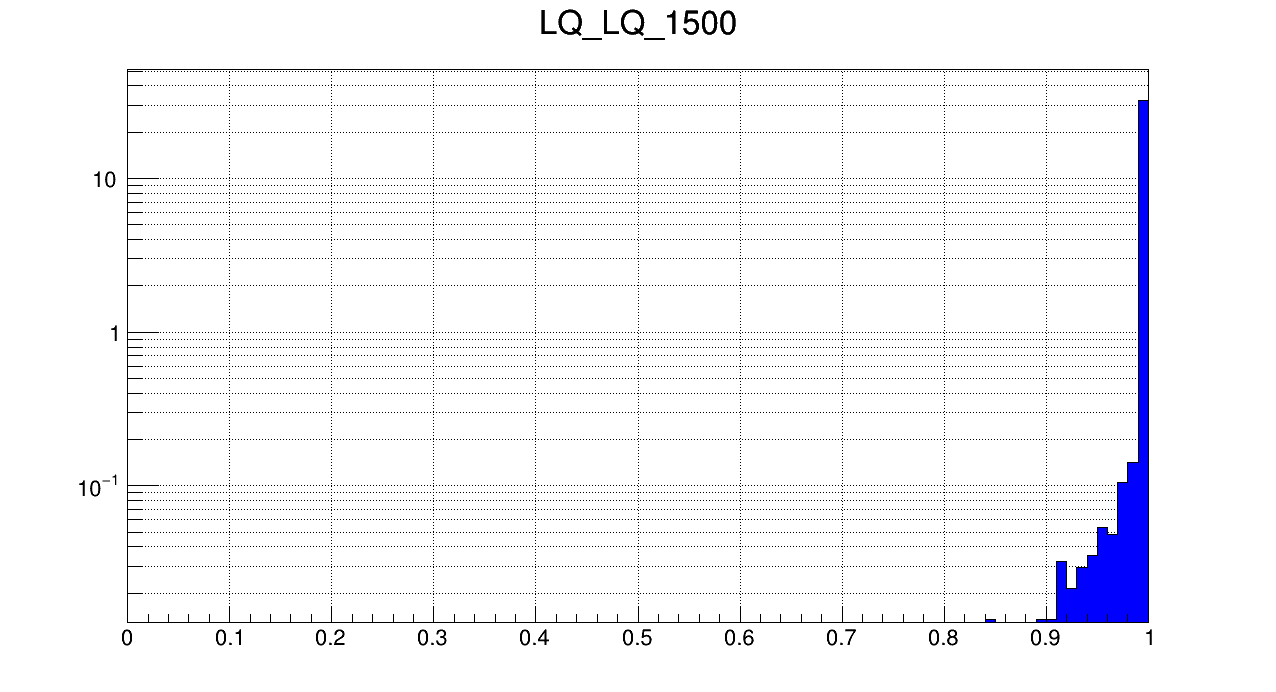

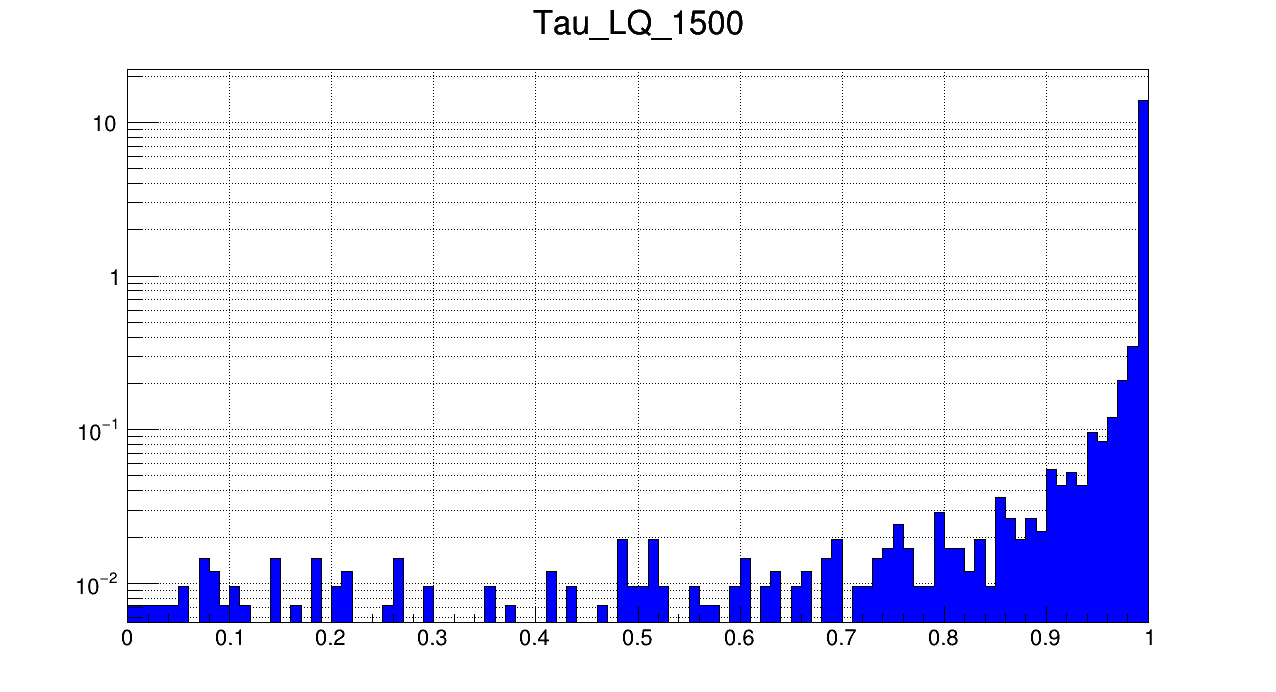

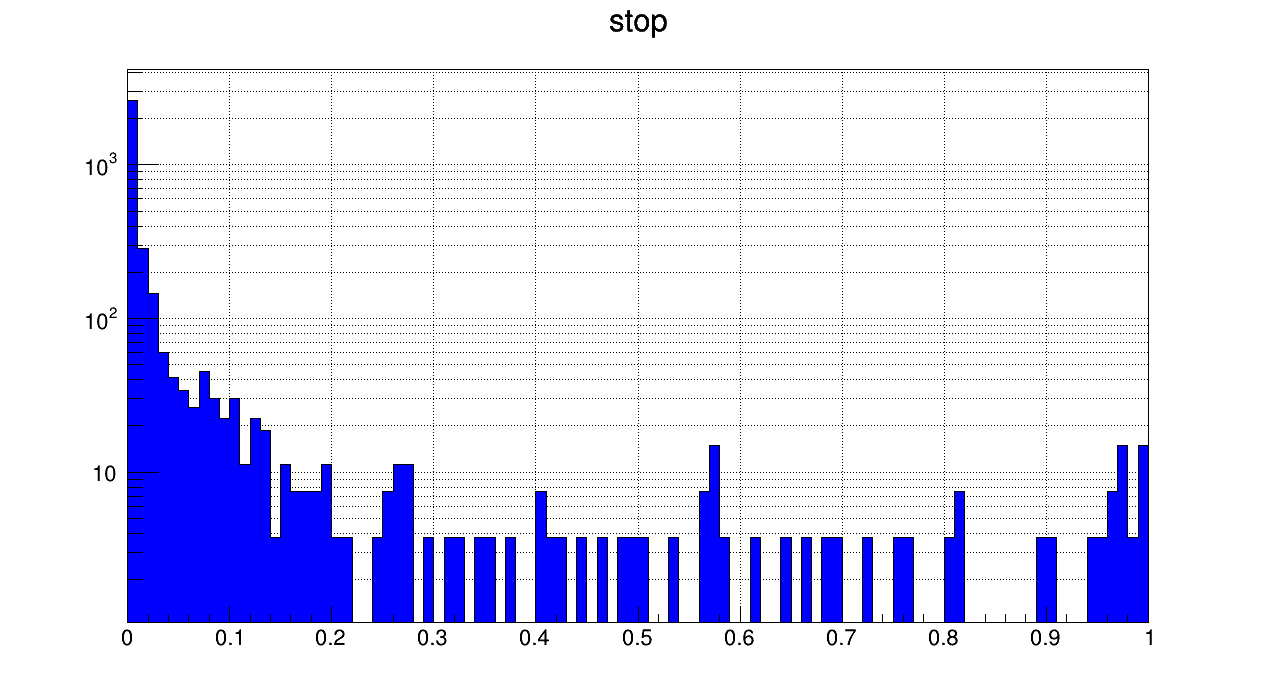

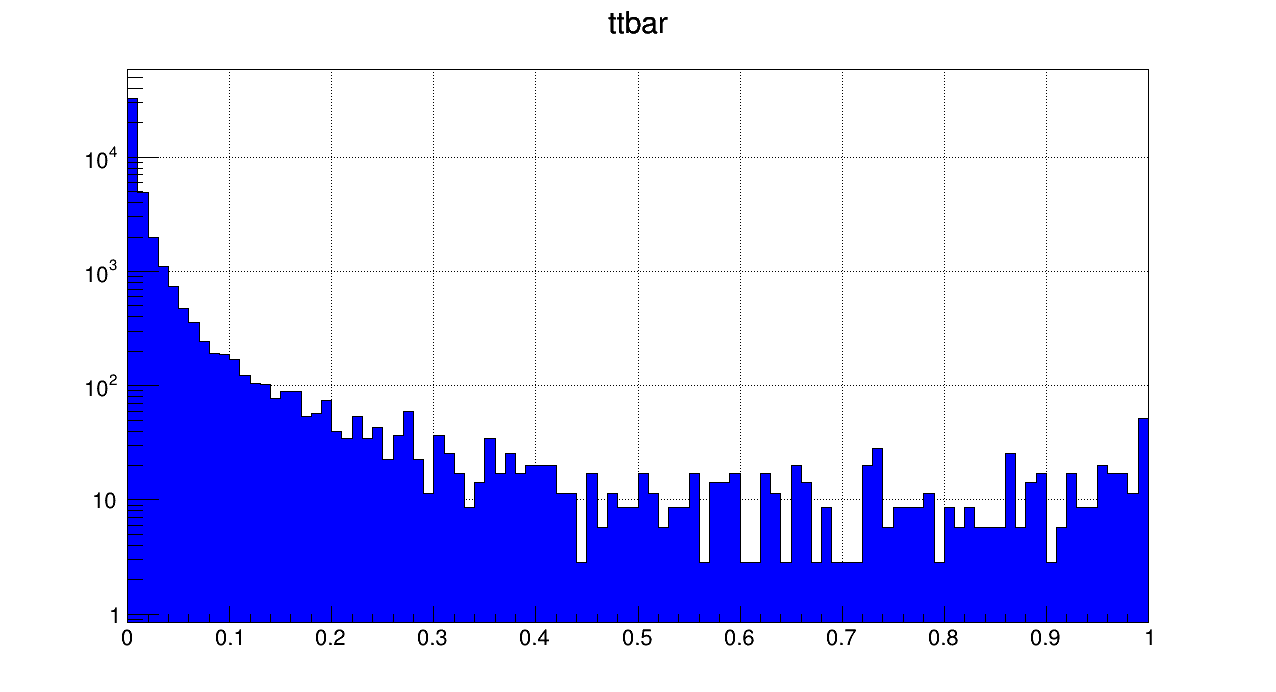

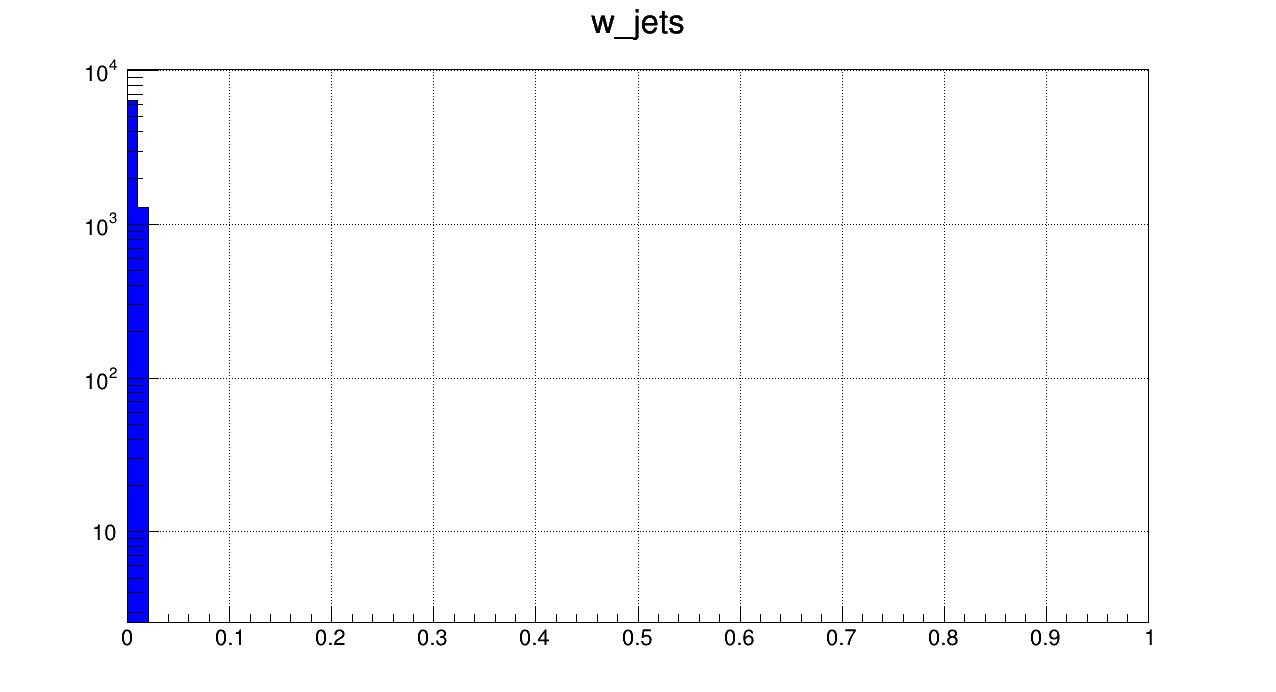

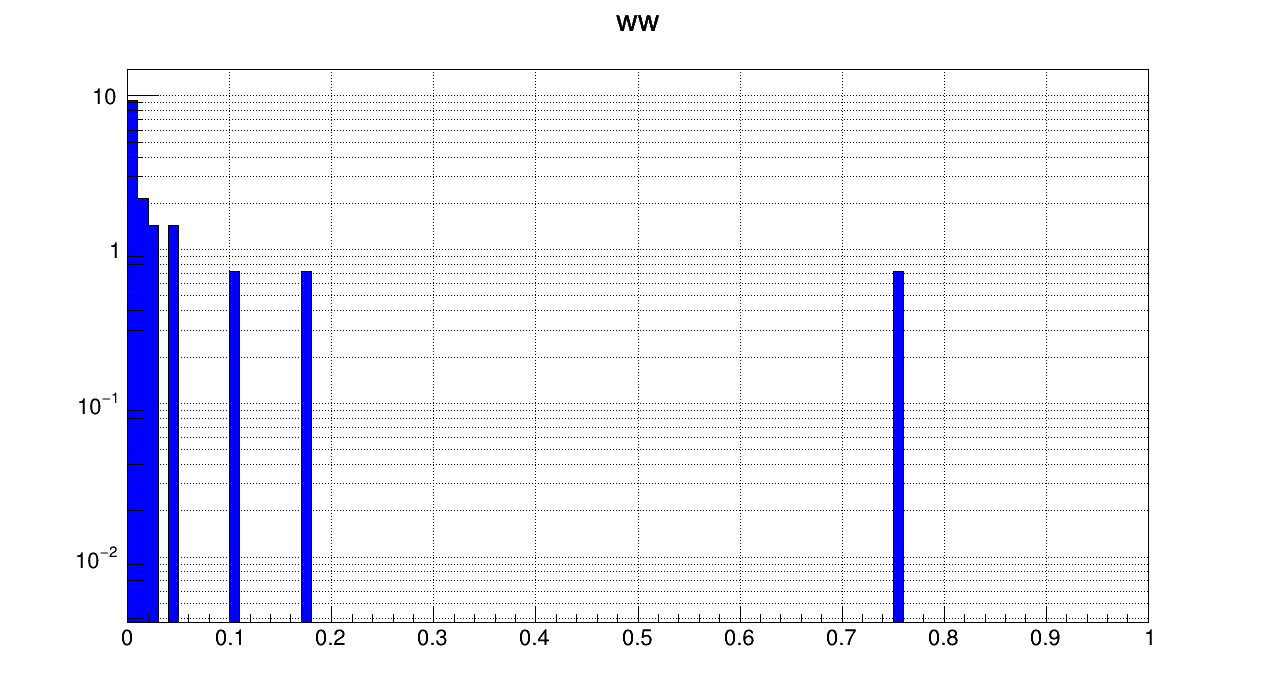

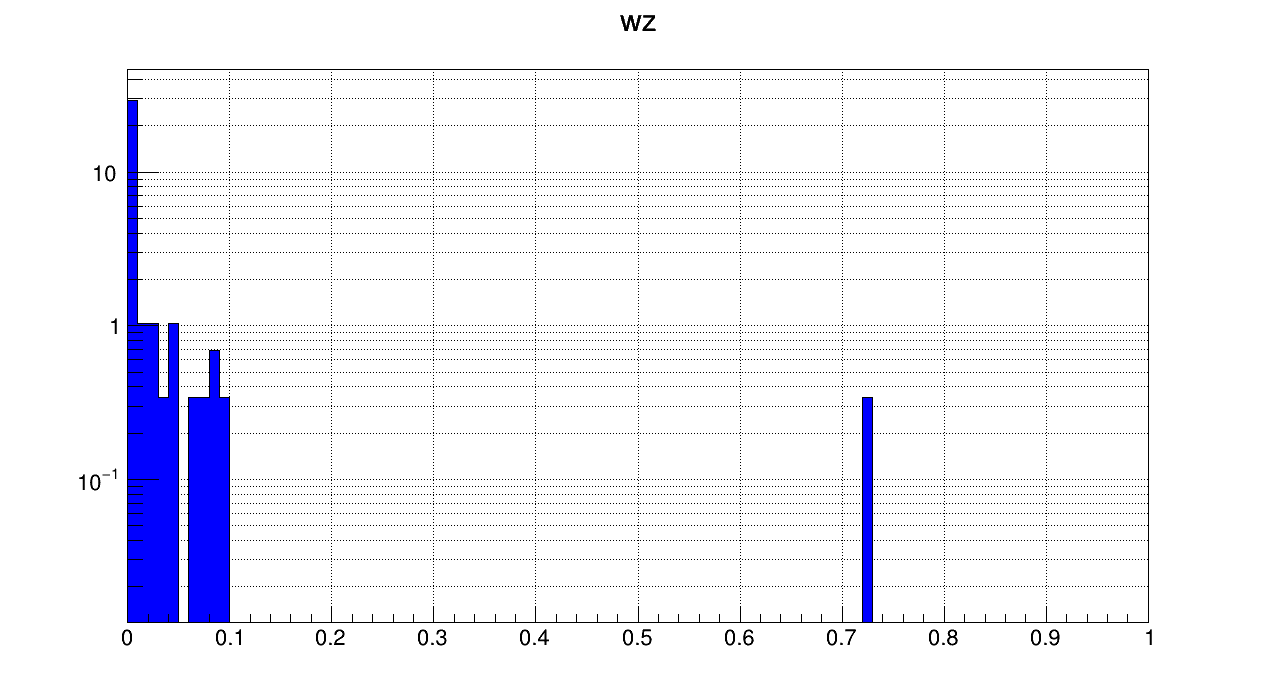

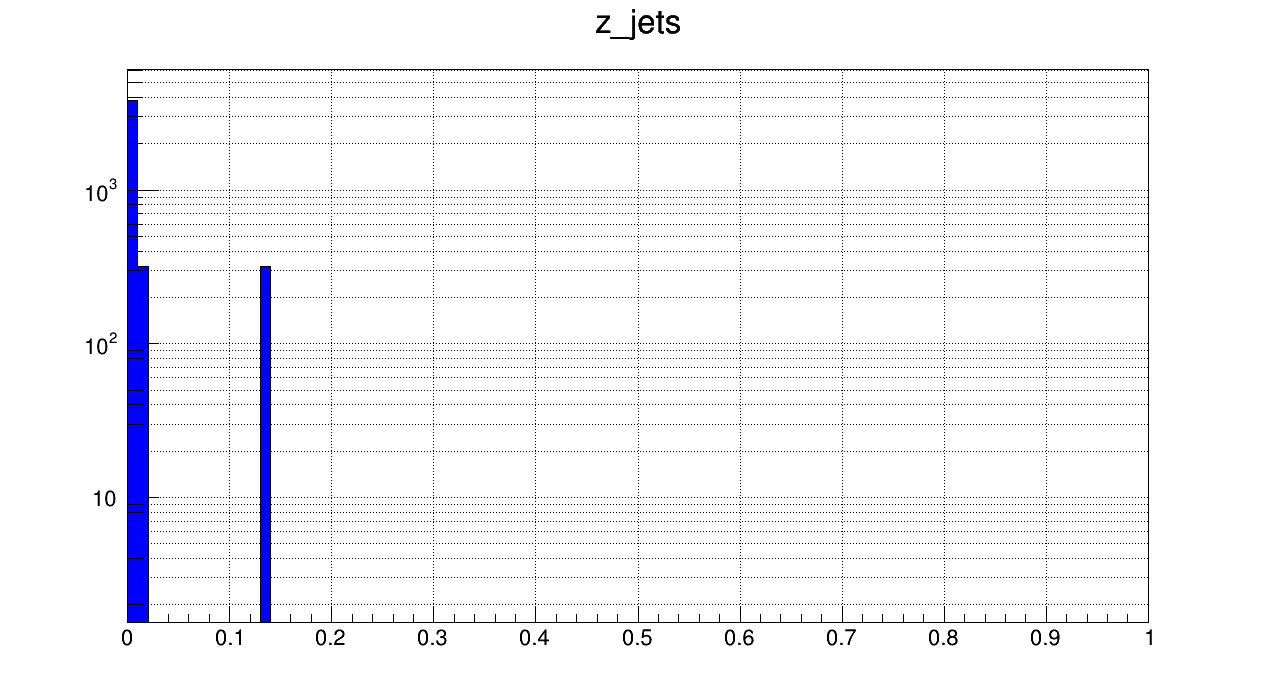

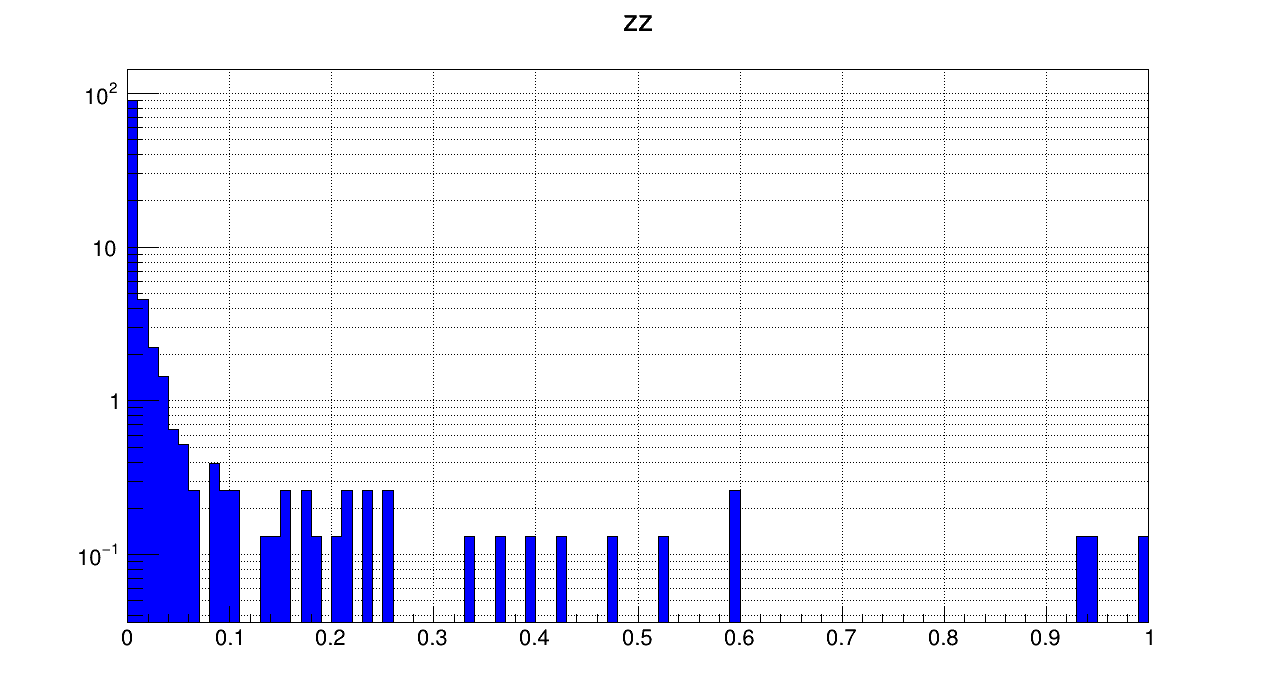

In [18]:
from IPython.display import Image, display
listOfImageNames=[]
files=next(os.walk(images_folder))[2]
for file in files:
    if ".png" in file:
        listOfImageNames+=[file]
listOfImageNames.sort()
for imageName in listOfImageNames:
    display(Image(filename=os.path.join(os.getcwd(),images_folder,imageName)))

In [19]:
histograms

{'Tau_LQ_1500': {'b_b_tau_tau_hadronic': <cppyy.gbl.TH1F object at 0x55f1cda07b60>},
 'LQ_LQ_1500': {'b_b_tau_tau_hadronic': <cppyy.gbl.TH1F object at 0x55f1e1ee1f70>},
 'ttbar': {'b_b_tau_tau_hadronic': <cppyy.gbl.TH1F object at 0x55f1cc0705c0>},
 'stop': {'b_b_tau_tau_hadronic': <cppyy.gbl.TH1F object at 0x55f1cafbe6f0>},
 'z_jets': {'b_b_tau_tau_hadronic': <cppyy.gbl.TH1F object at 0x55f1cb5a4870>},
 'w_jets': {'b_b_tau_tau_hadronic': <cppyy.gbl.TH1F object at 0x55f1cac642e0>},
 'ww': {'b_b_tau_tau_hadronic': <cppyy.gbl.TH1F object at 0x55f1e6214a10>},
 'wz': {'b_b_tau_tau_hadronic': <cppyy.gbl.TH1F object at 0x55f1caa2aa90>},
 'zz': {'b_b_tau_tau_hadronic': <cppyy.gbl.TH1F object at 0x55f1e1ed2e20>}}

In [20]:
threshold=0.8

In [21]:
integral=0
for channel in channels:
    h=histograms[name][channel]
    gbin1=h.FindBin(threshold)
    gbin2=h.GetMaximumBin()
    integral+=h.Integral(gbin1,gbin2)
integral

15.114062000066042

In [22]:
actual_signal_yield=0
for name in signal_names:
    integral=0
    for channel in channels:
        h=histograms[name][channel]
        gbin1=h.FindBin(threshold)
        gbin2=h.GetMaximumBin()
        integral+=h.Integral(gbin1,gbin2)
    integral
    actual_signal_yield+=integral
print(signal_names,actual_signal_yield)

['Tau_LQ_1500', 'LQ_LQ_1500'] 47.78628038521856


In [23]:
actual_bkg_yield=0
for name in bkg_names:
    integral=0
    for channel in channels:
        h=histograms[name][channel]
        gbin1=h.FindBin(threshold)
        gbin2=h.GetMaximumBin()
        integral+=h.Integral(gbin1,gbin2)
    actual_bkg_yield+=integral
print(bkg_names,actual_bkg_yield)

['ttbar', 'stop', 'z_jets', 'w_jets', 'ww', 'wz', 'zz'] 329.67465199530125


In [24]:
significance=actual_signal_yield/math.sqrt(actual_signal_yield+actual_bkg_yield)
significance

2.4596155090483167

In [25]:
def get_yield_by_names(hists,names,threshold):
    signal_yield=0
    for name in names:
        integral=0
        for channel in channels:
            h=histograms[name][channel]
            gbin1=h.FindBin(threshold)
            gbin2=h.GetMaximumBin()
            integral+=h.Integral(gbin1,gbin2)
        integral
        signal_yield+=integral
    return signal_yield

In [26]:
def get_sig_by_threshold(histos,threshold=0.5):
    actual_signal_yield=get_yield_by_names(histos,signal_names,threshold)
    actual_bkg_yield=get_yield_by_names(histos,bkg_names,threshold)
    return (actual_signal_yield)/math.sqrt((actual_signal_yield)+(actual_bkg_yield)+1e-6)

In [27]:
get_sig_by_threshold(histograms,0.99)

4.33721119884177

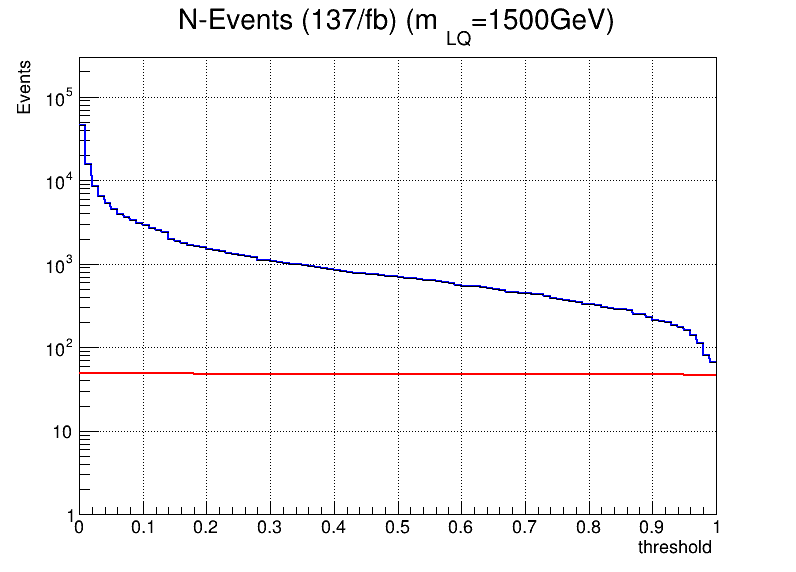

In [28]:
x=[]
y1=[]
y2=[]
n=1000
for i in range(n+1):
    x+=[i*(1./float(n))]
    y1+=[get_yield_by_names(histograms,bkg_names,x[i])]
    y2+=[get_yield_by_names(histograms,signal_names,x[i])]
x  = np.array(  x )
y1  = np.array(  y1 )
y2  = np.array(  y2 )

c2=TCanvas("c2","",800,600)
c2.SetLogy()
c2.SetGrid()
graph1=TGraph(n, x, y1)
graph1.SetTitle("N-Events (137/fb) (m_{LQ}=1500GeV);threshold; Events")
graph1.GetXaxis().SetLimits(0,1)
graph1.GetHistogram().SetMinimum(1)
graph1.GetHistogram().SetMaximum(3e5)
graph1.Draw("ALP")
graph1.SetLineColor(ROOT.kBlue)
graph1.SetLineWidth(2)

graph2=TGraph(n, x, y2)
graph2.Draw("l-same")
graph2.SetLineColor(ROOT.kRed)
graph2.SetLineWidth(2)
c2.Draw()

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c2


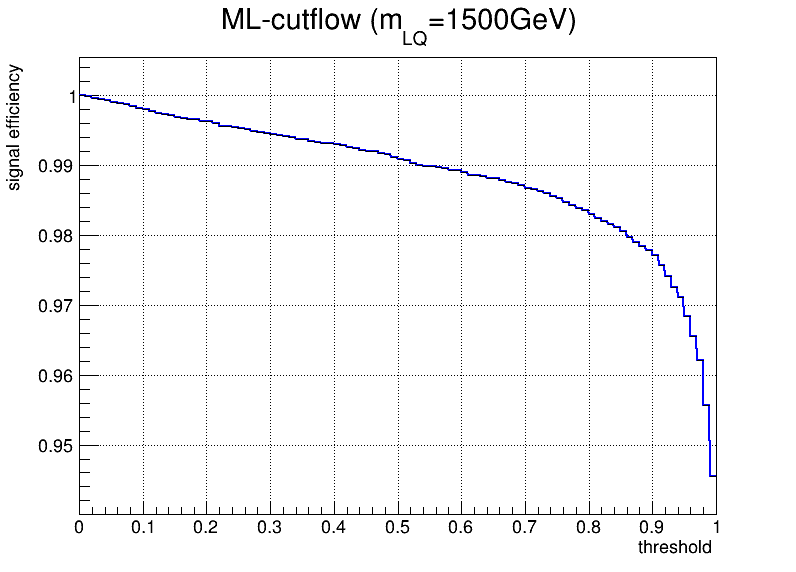

In [29]:
x=[]
y=[]
n=1000
for i in range(n+1):
    x+=[i*(1./float(n))]
    y+=[get_yield_by_names(histograms,signal_names,x[i])]
x  = np.array(  x )
y  = np.array(  y )/y[0]

c2=TCanvas("c2","",800,600)
c2.SetGrid()
graph=TGraph(n, x, y)
graph.SetTitle("ML-cutflow (m_{LQ}=1500GeV);threshold;signal efficiency")
graph.GetXaxis().SetLimits(0,1)
graph.Draw("ALP")
graph.SetLineColor(ROOT.kBlue)
graph.SetLineWidth(2)
c2.Draw()

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c2


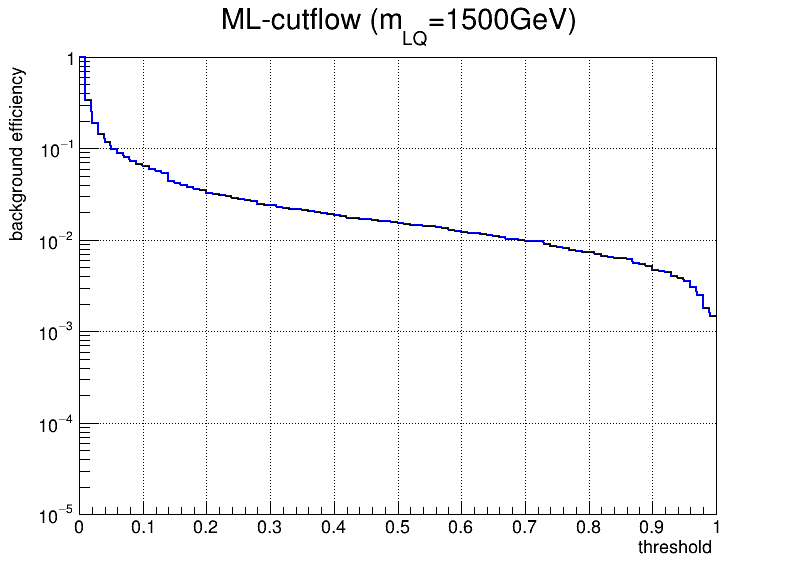

In [30]:
x=[]
y=[]
n=1000
for i in range(n+1):
    x+=[i*(1./float(n))]
    y+=[get_yield_by_names(histograms,bkg_names,x[i])]
x  = np.array(  x )
y  = np.array(  y )/y[0]

c2=TCanvas("c2","",800,600)
c2.SetLogy()
c2.SetGrid()
graph=TGraph(n, x, y)
graph.SetTitle("ML-cutflow (m_{LQ}=1500GeV);threshold;background efficiency")
graph.GetXaxis().SetLimits(0,1)
graph.GetHistogram().SetMinimum(1e-5)
graph.GetHistogram().SetMaximum(1)
graph.Draw("ALP")
graph.SetLineColor(ROOT.kBlue)
graph.SetLineWidth(2)
c2.Draw()

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c2


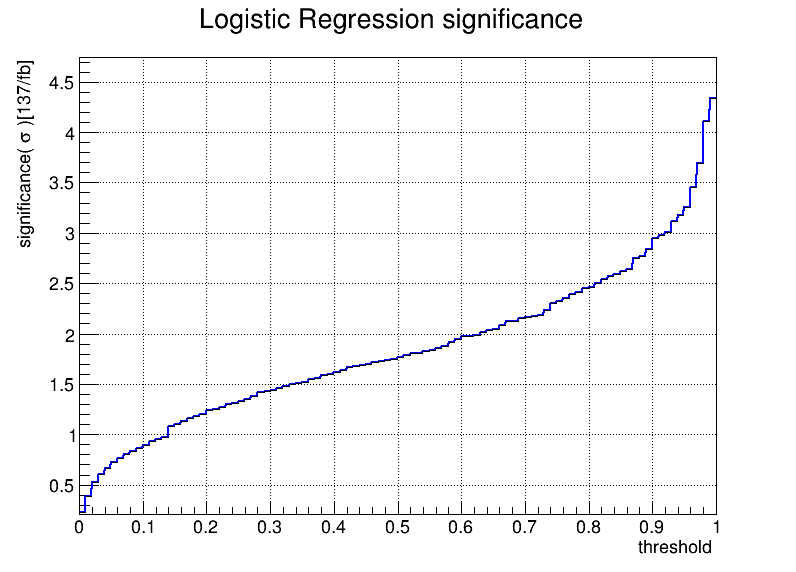

In [31]:
x=[]
y=[]
n=1000
for i in range(n+1):
    x+=[i*(1./float(n))]
    y+=[get_sig_by_threshold(histograms,x[i])]
x  = np.array(  x )
y  = np.array(  y )
c2=TCanvas("c2","",800,600)
c2.SetGrid()
graph=TGraph(n, x, y)
graph.SetTitle("Logistic Regression significance;threshold;significance(#sigma )[137/fb]")
graph.GetXaxis().SetLimits(0,1)
graph.Draw("ALP")
graph.SetLineColor(ROOT.kBlue)
graph.SetLineWidth(2)
c2.Draw()

In [32]:
x=[]
y=[]
n=100
for i in range(n+1):
    x+=[i*(1./float(n))]
    y+=[get_sig_by_threshold(histograms,x[i])]
x  = np.array(  x  )
y  = np.array(  y  )
print(y)

[0.22811179 0.39091913 0.52270951 0.6031492  0.66580431 0.72081528
 0.7648524  0.80417206 0.83791189 0.86683117 0.89737331 0.92985134
 0.95330423 0.97754652 1.07863483 1.10046152 1.12977366 1.16018576
 1.18150686 1.20450125 1.23755893 1.25522266 1.27125195 1.29549887
 1.3116365  1.33438797 1.34995673 1.3756471  1.41679908 1.41679908
 1.43991681 1.46391348 1.48388725 1.49852346 1.50441362 1.51762679
 1.54643812 1.5601036  1.58433531 1.59894061 1.61656642 1.64185228
 1.66431177 1.67955048 1.69073891 1.69737889 1.71544489 1.72544429
 1.73812571 1.75140494 1.76535978 1.79012872 1.80357304 1.8106361
 1.82631392 1.83764221 1.86058732 1.87489031 1.87489031 1.9454048
 1.97321096 1.97717265 1.98830673 2.01761183 2.03767016 2.04976547
 2.08756537 2.1232127  2.12892814 2.15439848 2.16804371 2.17403456
 2.179884   2.23552923 2.30716273 2.32163704 2.3567036  2.39155841
 2.41662694 2.45191586 2.45961551 2.49943828 2.5447679  2.57531958
 2.59554092 2.61651073 2.63695881 2.74525901 2.77015098 2.837738

In [34]:
histograms

{'Tau_LQ_1500': {'b_b_tau_tau_hadronic': <cppyy.gbl.TH1F object at 0x55f1cda07b60>},
 'LQ_LQ_1500': {'b_b_tau_tau_hadronic': <cppyy.gbl.TH1F object at 0x55f1e1ee1f70>},
 'ttbar': {'b_b_tau_tau_hadronic': <cppyy.gbl.TH1F object at 0x55f1cc0705c0>},
 'stop': {'b_b_tau_tau_hadronic': <cppyy.gbl.TH1F object at 0x55f1cafbe6f0>},
 'z_jets': {'b_b_tau_tau_hadronic': <cppyy.gbl.TH1F object at 0x55f1cb5a4870>},
 'w_jets': {'b_b_tau_tau_hadronic': <cppyy.gbl.TH1F object at 0x55f1cac642e0>},
 'ww': {'b_b_tau_tau_hadronic': <cppyy.gbl.TH1F object at 0x55f1e6214a10>},
 'wz': {'b_b_tau_tau_hadronic': <cppyy.gbl.TH1F object at 0x55f1caa2aa90>},
 'zz': {'b_b_tau_tau_hadronic': <cppyy.gbl.TH1F object at 0x55f1e1ed2e20>}}

In [35]:
from ROOT import TFile
from ROOT import TObject
import os
f=TFile(os.path.join(images_folder,"hist.root"),"RECREATE")
for signal in histograms:
    h=histograms[signal][channel]
    h.Write(f.GetName().removesuffix(".root"), TObject.kSingleKey)

Name: Tau_LQ_1500_b_b_tau_tau_hadronic Title: Tau_LQ_1500_b_b_tau_tau_hadronic NbinsX: 100
Name: LQ_LQ_1500_b_b_tau_tau_hadronic Title: LQ_LQ_1500_b_b_tau_tau_hadronic NbinsX: 100
Name: ttbar_b_b_tau_tau_hadronic Title: ttbar_b_b_tau_tau_hadronic NbinsX: 100
Name: stop_b_b_tau_tau_hadronic Title: stop_b_b_tau_tau_hadronic NbinsX: 100
Name: z_jets_b_b_tau_tau_hadronic Title: z_jets_b_b_tau_tau_hadronic NbinsX: 100
Name: w_jets_b_b_tau_tau_hadronic Title: w_jets_b_b_tau_tau_hadronic NbinsX: 100
Name: ww_b_b_tau_tau_hadronic Title: ww_b_b_tau_tau_hadronic NbinsX: 100
Name: wz_b_b_tau_tau_hadronic Title: wz_b_b_tau_tau_hadronic NbinsX: 100
Name: zz_b_b_tau_tau_hadronic Title: zz_b_b_tau_tau_hadronic NbinsX: 100


In [38]:
f=TFile(os.path.join(images_folder,"hist.root"),"RECREATE")


'b_b_tau_tau_hadronic-Mlq_1500/hist'